<a href="https://colab.research.google.com/github/Embeddedkuba/wakewords/blob/main/tensorflow_01_speech_commands_mfcc_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
!pip install python_speech_features
import python_speech_features

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Dataset path and view possible targets
dataset_path = '/content/drive/MyDrive/datasets1sfinal'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)
     

eight
dog
down
backward
bird
bed
forward
five
follow
cat
no
house
four
learn
go
nine
off
left
marvin
happy
stop
three
on
six
seven
two
right
tree
sheila
one
up
pawntosolo


In [10]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.sort()
print(all_targets)


['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'pawntosolo', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up']


In [11]:
# Leave off background noise set
#all_targets.remove('PawnToSOLO')
# all_targets.remove('dog')
# all_targets.remove('bird')
# all_targets.remove('bed')
# all_targets.remove('no')
# all_targets.remove('house')
# all_targets.remove('off')
# all_targets.remove('marvin')
# all_targets.remove('happy')
# all_targets.remove('follow')
# all_targets.remove('tree')
# all_targets.remove('learn')
# all_targets.remove('sheila') 

print(all_targets)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'pawntosolo', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up']


In [12]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

1664
2025
2074
2070
2159
3986
3910
4073
1579
1557
3728
3880
2054
2113
1575
3801
2100
3934
3941
3745
3849
3890
2437
3778
3998
2022
3860
3872
3727
1759
3880
3723
Total samples: 96763


In [13]:
# Settings
target_list = all_targets
feature_sets_file = '/content/drive/MyDrive/datasets1sfinal/all_targets_mfcc_sets.npz'
perc_keep_samples = 0.5 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16


In [14]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

/content/drive/MyDrive/datasets1sfinal/backward
/content/drive/MyDrive/datasets1sfinal/bed
/content/drive/MyDrive/datasets1sfinal/bird
/content/drive/MyDrive/datasets1sfinal/cat
/content/drive/MyDrive/datasets1sfinal/dog
/content/drive/MyDrive/datasets1sfinal/down
/content/drive/MyDrive/datasets1sfinal/eight
/content/drive/MyDrive/datasets1sfinal/five
/content/drive/MyDrive/datasets1sfinal/follow
/content/drive/MyDrive/datasets1sfinal/forward
/content/drive/MyDrive/datasets1sfinal/four
/content/drive/MyDrive/datasets1sfinal/go
/content/drive/MyDrive/datasets1sfinal/happy
/content/drive/MyDrive/datasets1sfinal/house
/content/drive/MyDrive/datasets1sfinal/learn
/content/drive/MyDrive/datasets1sfinal/left
/content/drive/MyDrive/datasets1sfinal/marvin
/content/drive/MyDrive/datasets1sfinal/nine
/content/drive/MyDrive/datasets1sfinal/no
/content/drive/MyDrive/datasets1sfinal/off
/content/drive/MyDrive/datasets1sfinal/on
/content/drive/MyDrive/datasets1sfinal/one
/content/drive/MyDrive/datas

In [15]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]), array([2., 2., 2., ..., 2., 2., 2.]), array([3., 3., 3., ..., 3., 3., 3.]), array([4., 4., 4., ..., 4., 4., 4.]), array([5., 5., 5., ..., 5., 5., 5.]), array([6., 6., 6., ..., 6., 6., 6.]), array([7., 7., 7., ..., 7., 7., 7.]), array([8., 8., 8., ..., 8., 8., 8.]), array([9., 9., 9., ..., 9., 9., 9.]), array([10., 10., 10., ..., 10., 10., 10.]), array([11., 11., 11., ..., 11., 11., 11.]), array([12., 12., 12., ..., 12., 12., 12.]), array([13., 13., 13., ..., 13., 13., 13.]), array([14., 14., 14., ..., 14., 14., 14.]), array([15., 15., 15., ..., 15., 15., 15.]), array([16., 16., 16., ..., 16., 16., 16.]), array([17., 17., 17., ..., 17., 17., 17.]), array([18., 18., 18., ..., 18., 18., 18.]), array([19., 19., 19., ..., 19., 19., 19.]), array([20., 20., 20., ..., 20., 20., 20.]), array([21., 21., 21., ..., 21., 21., 21.]), array([22., 22., 22., ..., 22., 22., 22.]), array([23., 23., 23., ..., 23., 23., 23.]), arr

In [16]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [17]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [18]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

96763
48381


In [19]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [20]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]


In [21]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [22]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [23]:

# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc: #why equal!?
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

Dropped: 5 (16, 11)
Dropped: 14 (16, 9)
Dropped: 20 (16, 9)
Dropped: 25 (16, 7)
Dropped: 26 (16, 14)
Dropped: 27 (16, 15)
Dropped: 53 (16, 14)
Dropped: 66 (16, 14)
Dropped: 72 (16, 5)
Dropped: 98 (16, 7)
Dropped: 104 (16, 15)
Dropped: 105 (16, 13)
Dropped: 112 (16, 12)
Dropped: 157 (16, 10)
Dropped: 165 (16, 15)
Dropped: 172 (16, 13)
Dropped: 189 (16, 10)
Dropped: 193 (16, 14)
Dropped: 194 (16, 15)
Dropped: 199 (16, 13)
Dropped: 206 (16, 11)
Dropped: 222 (16, 7)
Dropped: 241 (16, 7)
Dropped: 244 (16, 7)
Dropped: 266 (16, 13)
Dropped: 269 (16, 15)
Dropped: 286 (16, 11)
Dropped: 291 (16, 13)
Dropped: 309 (16, 11)
Dropped: 321 (16, 10)
Dropped: 340 (16, 6)
Dropped: 347 (16, 15)
Dropped: 349 (16, 8)
Dropped: 361 (16, 5)
Dropped: 363 (16, 11)
Dropped: 364 (16, 8)
Dropped: 367 (16, 14)
Dropped: 368 (16, 12)
Dropped: 388 (16, 7)
Dropped: 395 (16, 11)
Dropped: 413 (16, 4)
Dropped: 417 (16, 11)
Dropped: 424 (16, 9)
Dropped: 427 (16, 8)
Dropped: 436 (16, 13)
Dropped: 439 (16, 10)
Dropped: 446 (1

In [24]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.098


  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7037 sha256=30ab8315527f71e5b786b9c1c6c405f45477d642b3b89dbaf28b7959cab3483e
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


MFCCs: [[-8.16247985e+01 -8.33304254e+01 -8.33642804e+01 -8.44893837e+01
  -8.63959987e+01 -5.79274997e+01 -2.92520983e+01 -1.70604261e+01
  -1.16700043e+01 -1.10168459e+01 -1.39591631e+01 -1.90568470e+01
  -2.46417408e+01 -3.03338465e+01 -3.68516727e+01 -4.35923626e+01]
 [-1.74335645e+00 -8.94137257e-01 -4.07461652e-01 -3.31273439e-01
   1.61995632e-01 -1.20114238e+00  5.37514729e-01  2.37254769e-01
   2.82606344e-01  9.46870917e-01  2.82483109e+00  5.50233144e+00
   7.65905430e+00  9.62483904e+00  9.94743327e+00  5.94991847e+00]
 [ 2.71555026e+00  1.18523649e+00 -2.07700715e-01 -8.45310363e-01
  -1.18114074e+00 -3.70700777e+00  1.18345813e+00  6.60220268e-01
  -1.13527197e+00 -3.11905629e+00 -4.87976990e+00 -5.96721633e+00
  -5.56701519e+00 -4.25946182e+00 -1.78549638e+00  2.95794321e+00]
 [ 1.24867098e+00  2.76719475e+00  4.42191045e+00  4.06512944e+00
   2.67169750e+00 -8.46680988e-01 -6.37961745e-02 -3.82330802e-01
  -3.03442708e-01  3.57712389e-01  1.00647513e+00  7.01895653e-01


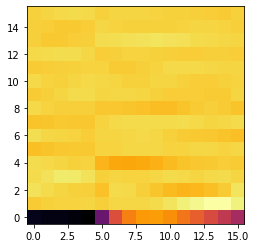

In [25]:
# TEST: Test shorter MFCC
!pip install playsound
from playsound import playsound

idx = 1

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
#playsound(path) cannot playsound on colab!

In [26]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length -> why!?
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [27]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
#print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
#print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
#print('Removed percentage:', prob / len(y_orig_test))

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Dropped: 1852 (16, 13)
Dropped: 1859 (16, 10)
Dropped: 1864 (16, 9)
Dropped: 1874 (16, 14)
Dropped: 1879 (16, 11)
Dropped: 1885 (16, 14)
Dropped: 1896 (16, 12)
Dropped: 1900 (16, 12)
Dropped: 1902 (16, 14)
Dropped: 1920 (16, 12)
Dropped: 1940 (16, 13)
Dropped: 1944 (16, 11)
Dropped: 1950 (16, 14)
Dropped: 1962 (16, 13)
Dropped: 1963 (16, 11)
Dropped: 1971 (16, 14)
Dropped: 1975 (16, 12)
Dropped: 1983 (16, 13)
Dropped: 1984 (16, 12)
Dropped: 2004 (16, 9)
Dropped: 2007 (16, 7)
Dropped: 2008 (16, 12)
Dropped: 2016 (16, 11)
Dropped: 2031 (16, 14)
Dropped: 2048 (16, 8)
Dropped: 2049 (16, 14)
Dropped: 2050 (16, 14)
Dropped: 2051 (16, 13)
Dropped: 2054 (16, 6)
Dropped: 2063 (16, 9)
Dropped: 2071 (16, 15)
Dropped: 2086 (16, 14)
Dropped: 2089 (16, 13)
Dropped: 2104 (16, 14)
Dropped: 2106 (16, 14)
Dropped: 2111 (16, 13)
Dropped: 2114 (16, 13)
Dropped: 2133 (16, 7)
Dropped: 2151 (16, 14)
Dropped: 2159 (16, 7)
Dropped: 2175 (16, 15)


In [28]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [29]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [30]:
len(feature_sets['x_train'])

34539

In [31]:
print(feature_sets['y_val'])

[10. 31. 29. ...  7. 30. 25.]


In [32]:
print('xxhx')

xxhx
